# CЕМИНАР 2: ПОЛЕЗНЫЕ ФУНКЦИИ, МОДЕЛИРОВАНИЕ РАСПРЕДЕЛЕНИЙ И МЕТОД МОНТЕ-КАРЛО

На вводных лекциях мы познакомились с понятиями вероятности (в задачах с разными постановками), случайных величин, их распределений и плотности

В качестве первой практики попробуем поработать с самыми простыми способами моделирования реальных процессов, а также рассмотрим метод Монте-Карло и где он может быть полезен


In [2]:
import random
import numpy as np
import scipy.stats as stats
import math

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

## ПРАКТИКА: прогноз выручки кофейни

Будем работать с данными, которые содержат покупки напитков в кофейне с марта 2024 по март 2025 года <br>

Данные и их описание: <https://www.kaggle.com/datasets/navjotkaushal/coffee-sales-dataset/data>


In [4]:
import pandas as pd

df = pd.read_csv("Coffe_sales.csv")
df

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.70,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.70,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.70,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.90,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.70,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000
...,...,...,...,...,...,...,...,...,...,...,...
3542,10,card,35.76,Cappuccino,Morning,Sun,Mar,7,3,2025-03-23,10:34:54.894000
3543,14,card,35.76,Cocoa,Afternoon,Sun,Mar,7,3,2025-03-23,14:43:37.362000
3544,14,card,35.76,Cocoa,Afternoon,Sun,Mar,7,3,2025-03-23,14:44:16.864000
3545,15,card,25.96,Americano,Afternoon,Sun,Mar,7,3,2025-03-23,15:47:28.723000


Нас, большей частью, интересует поток посетителей, а если быть точнее: выручка <br>

В датасете представлено не так много признаков: по факту мы имеем наименование напитка, дату и время, а также сумму чека <br>

Попробуем поработать с таким таргетом как выручка кофейни за день

### TASK 0
Разделите выборку на две части

Поместите  март 2025 в один датафрейм (это будет выборка для валидации)

Все остальные наблюдения - в другой (это будет "обучающая")

Далее будем работать с "обучающей" выборкой

In [7]:
### YOUR CODE HERE
df_valid = df.where(df['Date'].map(lambda x: x[:7] == '2025-03')).dropna()
df_valid

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
3228,10.0,card,35.76,Cappuccino,Morning,Sat,Mar,6.0,3.0,2025-03-01,10:31:45.742000
3229,11.0,card,25.96,Americano,Morning,Sat,Mar,6.0,3.0,2025-03-01,11:24:04.507000
3230,11.0,card,25.96,Americano,Morning,Sat,Mar,6.0,3.0,2025-03-01,11:27:58.402000
3231,14.0,card,35.76,Latte,Afternoon,Sat,Mar,6.0,3.0,2025-03-01,14:43:23.827000
3232,15.0,card,25.96,Americano,Afternoon,Sat,Mar,6.0,3.0,2025-03-01,15:02:31.500000
...,...,...,...,...,...,...,...,...,...,...,...
3542,10.0,card,35.76,Cappuccino,Morning,Sun,Mar,7.0,3.0,2025-03-23,10:34:54.894000
3543,14.0,card,35.76,Cocoa,Afternoon,Sun,Mar,7.0,3.0,2025-03-23,14:43:37.362000
3544,14.0,card,35.76,Cocoa,Afternoon,Sun,Mar,7.0,3.0,2025-03-23,14:44:16.864000
3545,15.0,card,25.96,Americano,Afternoon,Sun,Mar,7.0,3.0,2025-03-23,15:47:28.723000


In [8]:
df_train = df.where(df['Date'].map(lambda x: x[:7] != '2025-03')).dropna()
df_train

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10.0,card,38.70,Latte,Morning,Fri,Mar,5.0,3.0,2024-03-01,10:15:50.520000
1,12.0,card,38.70,Hot Chocolate,Afternoon,Fri,Mar,5.0,3.0,2024-03-01,12:19:22.539000
2,12.0,card,38.70,Hot Chocolate,Afternoon,Fri,Mar,5.0,3.0,2024-03-01,12:20:18.089000
3,13.0,card,28.90,Americano,Afternoon,Fri,Mar,5.0,3.0,2024-03-01,13:46:33.006000
4,13.0,card,38.70,Latte,Afternoon,Fri,Mar,5.0,3.0,2024-03-01,13:48:14.626000
...,...,...,...,...,...,...,...,...,...,...,...
3223,17.0,card,35.76,Latte,Night,Fri,Feb,5.0,2.0,2025-02-28,17:21:00.889000
3224,17.0,card,30.86,Americano with Milk,Night,Fri,Feb,5.0,2.0,2025-02-28,17:31:04.347000
3225,17.0,card,25.96,Americano,Night,Fri,Feb,5.0,2.0,2025-02-28,17:32:16.632000
3226,17.0,card,25.96,Americano,Night,Fri,Feb,5.0,2.0,2025-02-28,17:33:49.148000


### TASK 1

Создайте датафрейм с выручкой кофейни за день и визуализируйте частоту встречаемых значений

Для этого можете воспользоваться функцией plt.hist с параметром density=True, поэксперементировав с параметром bins

Похоже ли данное распределение на какое-либо из известных Вам? На какое?

А если взять логарифм?

In [10]:
##### YOUR CODE HERE
unique_dates = df_train['Date'].unique()
rewenues = []
for date in unique_dates:
    day_rewenue = df_train.where(df_train['Date'].map(lambda x: x == date)).dropna()['money'].sum()
    rewenues.append(day_rewenue)

C:\Users\alexb\AppData\Local\Temp\ipykernel_7408\2848146663.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rewenues, hist_kws={'edgecolor': 'black', 'color': '#069AF3'}, kde_kws={'color': 'red'})


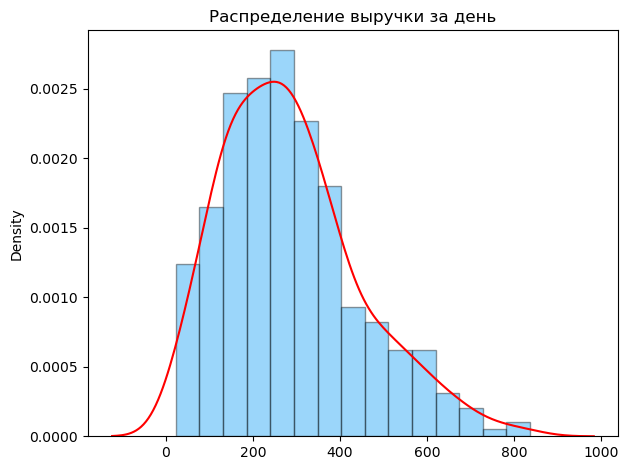

In [11]:
sns.distplot(rewenues, hist_kws={'edgecolor': 'black', 'color': '#069AF3'}, kde_kws={'color': 'red'})
plt.title('Распределение выручки за день')
plt.tight_layout()
plt.show()

C:\Users\alexb\AppData\Local\Temp\ipykernel_7408\4255109395.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rewenues_log, hist_kws={'edgecolor': 'black', 'color': '#069AF3'}, kde_kws={'color': 'red'})


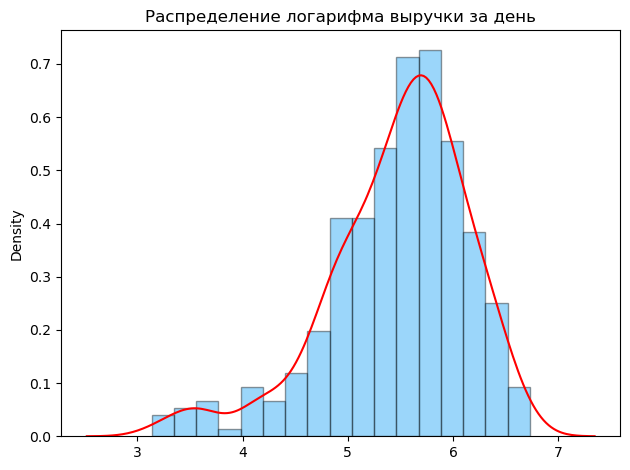

In [12]:
rewenues_log = list(map(lambda x: np.log(x), rewenues))
sns.distplot(rewenues_log, hist_kws={'edgecolor': 'black', 'color': '#069AF3'}, kde_kws={'color': 'red'})
plt.title('Распределение логарифма выручки за день')
plt.tight_layout()
plt.show()

#### Вывод
Распределение похоже на скошенное нормальное распределение (т.е. нормальное с асимметрией), можно попробовать смоделировать его, вычислив по имеющейся выборке математическое ожидание, среднеквадратичное отклонение и асимметрию

### TASK 2
* Попробуйте смоделировать распределение, которое наилучшим образом описывает выручку кофейни за день (ну или ее логарифм)
* Постройте теоретический график распределения вероятностей и наложите его на эмпирический
* На Ваш взгляд, достаточно ли они схожи?

       оригинальная выборка  сгенерированная выборка
count            358.000000               358.000000
mean             285.640056               335.976807
std              158.160520               144.076754
min               23.020000               -75.185069
25%              169.000000               233.927366
50%              268.670000               327.593282
75%              370.820000               430.940237
max              836.660000               743.514526


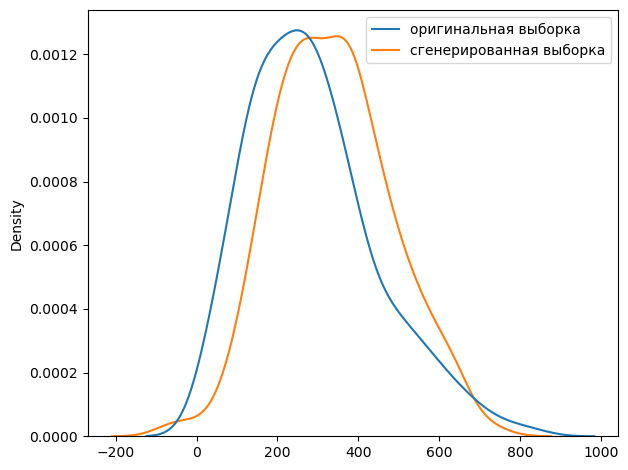

In [15]:
### YOUR CODE HERE
expectation = np.array(rewenues).mean()
std = np.array(rewenues).std()
skewness = stats.skew(rewenues)
# Так как выборка небольшая, постараемся подоюрать лучшую генерацию через перебор сида генерации
# Подберём лучшую генерацию
# best_seed = None
# best_pvalue = 0
# for seed in range(1, 100000):
#     np.random.seed(seed)
#     skenorm_values = stats.skewnorm.rvs(skewness, loc=expectation, scale=std, size=len(rewenues))
#     _, pvalue = stats.ks_2samp(rewenues, skenorm_values)
#     if pvalue > best_pvalue:
#         best_pvalue = pvalue
#         best_seed = seed
# print(f"Лучший seed: {best_seed}, лучший p-value: {best_pvalue}")
# Лучший seed: 43652, лучший p-value: 9.859679852379159e-06
np.random.seed(43652)
skenorm_values = stats.skewnorm.rvs(skewness, loc=expectation, scale=std, size=len(rewenues))
kdes = {'оригинальная выборка': rewenues,
        'сгенерированная выборка': skenorm_values}
df_kdes = pd.DataFrame(kdes)
print(df_kdes.describe())
sns.kdeplot(df_kdes)
plt.tight_layout()
plt.show()

По тесту Колмогорова-Смирнова результат генерации плохой, p-value ~= 0. Это интерпретируется так, что эти выборки принадлежат одному распределению с около нулевой вероятностю... 
Но внешнее сходство выглядит обнадёживающе)

### TASK 3

Попробуйте сделать прогноз с помощью получившейся модели: какова будет средняя выручка кофейни в течение следующего одного дня, пяти дней, десяти дней, двадцати восьми дней?

* Рекомендуем использовать метод Монте-Карло: генерировать из получившегося распределения выручку n раз, где n - кол-во дней
* Для более устойчивых результатов предыдущий шаг можно повторить несколько раз и взять среднюю величину (ну или построить доверительный интервал, если знаете как:)


* Оцените качество прогноза
* Устроил бы Вас в этой задаче такой результат?

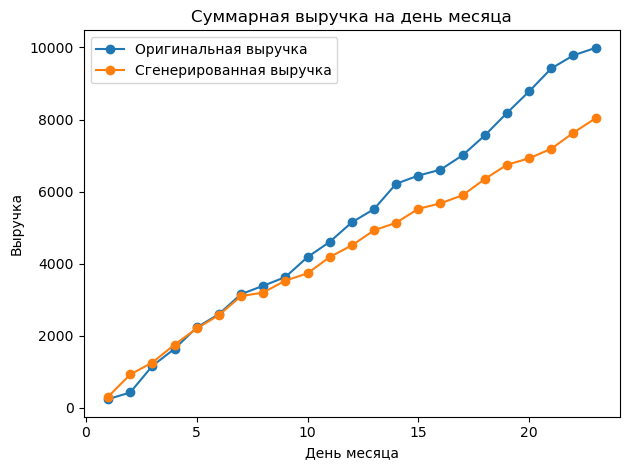

In [18]:
### YOUR CODE HERE
unique_dates_test = df_valid['Date'].unique()
rewenues_test = []
for date in unique_dates_test:
    day_rewenue = df_valid.where(df_valid['Date'].map(lambda x: x == date)).dropna()['money'].sum()
    rewenues_test.append(day_rewenue)
rewenues_test_cumsum = np.cumsum(rewenues_test)
np.random.seed(43652)
modeled = stats.skewnorm.rvs(skewness, loc=expectation, scale=std, size=len(rewenues_test))
modeled_cumsum = np.cumsum(modeled)
days = list(range(1, len(rewenues_test)+1))
plt.plot(days, rewenues_test_cumsum, marker='o', label='Оригинальная выручка')
plt.plot(days, modeled_cumsum, marker='o', label='Сгенерированная выручка')
plt.title('Суммарная выручка на день месяца')
plt.xlabel('День месяца')
plt.ylabel('Выручка')
plt.legend()
plt.tight_layout()
plt.show()

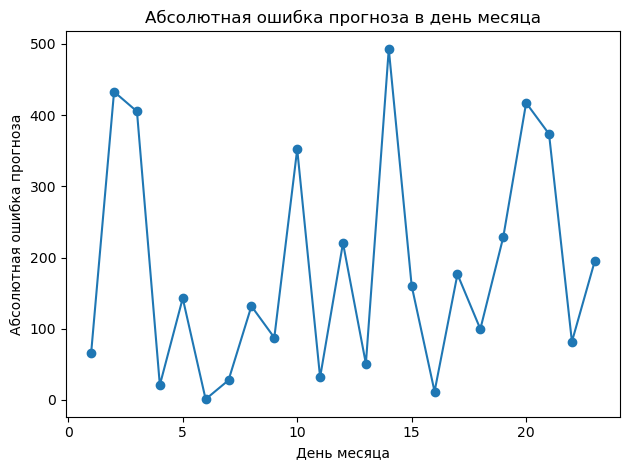

In [19]:
absolute_error = []
for i in range(len(rewenues_test)):
    absolute_error.append(abs(rewenues_test[i] - modeled[i]))
plt.plot(days, absolute_error, marker='o')
plt.title('Абсолютная ошибка прогноза в день месяца')
plt.xlabel('День месяца')
plt.ylabel('Абсолютная ошибка прогноза')
plt.tight_layout()
plt.show()

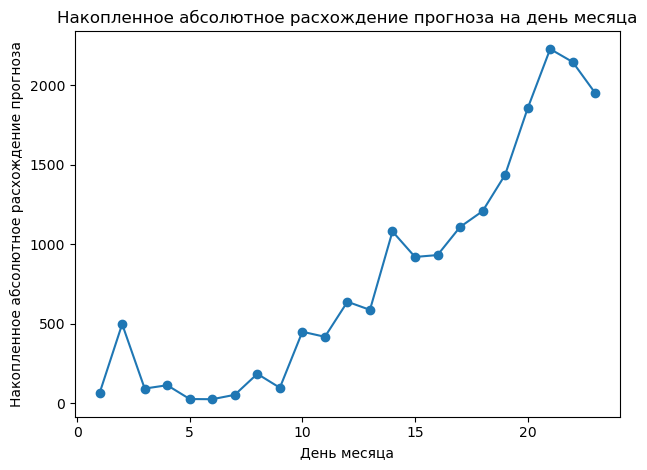

In [20]:
error_cumsum = []
for i in range(len(rewenues_test)):
    error_cumsum.append(abs(rewenues_test_cumsum[i] - modeled_cumsum[i]))
plt.plot(days, error_cumsum, marker='o')
plt.title('Накопленное абсолютное расхождение прогноза на день месяца')
plt.xlabel('День месяца')
plt.ylabel('Накопленное абсолютное расхождение прогноза')
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
print(f'Среднее расхождение в каждый день отдельно: абсолютное: {mean_absolute_error(rewenues_test, modeled):.2f}, процентное: {mean_absolute_percentage_error(rewenues_test, modeled)*100:.2f}% | средняя выручка за день: {np.array(rewenues_test).mean():.2f}')
print(f'Среднее накопленное расхождение на день месяца: абсолютное: {mean_absolute_error(rewenues_test_cumsum, modeled_cumsum):.2f}, процентное: {mean_absolute_percentage_error(rewenues_test_cumsum, modeled_cumsum)*100:.2f}%')

Среднее расхождение в каждый день отдельно: абсолютное: 183.01, процентное: 46.16% | средняя выручка за день: 434.19
Среднее накопленное расхождение на день месяца: абсолютное: 788.91, процентное: 17.22%


#### Вывод
Данный прогноз строится случайной генерацией значения из смоделированного распределения, поэтому в отдельном случае может иметь сильное расхождение с реальным значением, но суммарное расхождение за период в процентах значительно меньше, поэтому такой способ лучше применять для прогнозирования за период 

### TASK 4
Давайте чуть детальнее посмотрим на выборку

Проведите разведочный анализ данных

Некоторые идеи:

* В какие дни покупают больше напитков?
* В какое время?
* Одинакова ли цена на напитки в рассматриваемый временной промежуток?
* Как ведут себя частоты покупки разных напитков? (попробуйте нарисовать график, аналогичный прошлому заданию)
* Есть ли в выборке выбросы, стоит ли их удалять?

Какие выводы Вы можете сделать на основе проведенного анализа?

              Fri         Sat         Sun         Mon         Tue         Wed  \
count   49.000000   49.000000   49.000000   49.000000   49.000000   49.000000   
mean   260.008163  270.124082  252.040816  279.422449  313.901633  285.539592   
std    145.226057  130.535709  159.226152  159.992258  162.285904  163.965266   
min     67.600000   37.720000   28.900000   25.960000   32.820000   27.920000   
25%    154.300000  175.360000  138.120000  154.300000  192.020000  159.200000   
50%    235.620000  254.240000  240.520000  276.280000  289.000000  272.360000   
75%    312.040000  349.260000  339.460000  342.900000  403.640000  365.420000   
max    836.660000  579.940000  679.880000  796.000000  661.760000  760.240000   

              Thu  
count   49.000000  
mean   276.852653  
std    137.674979  
min     23.020000  
25%    169.000000  
50%    271.380000  
75%    357.100000  
max    726.460000  


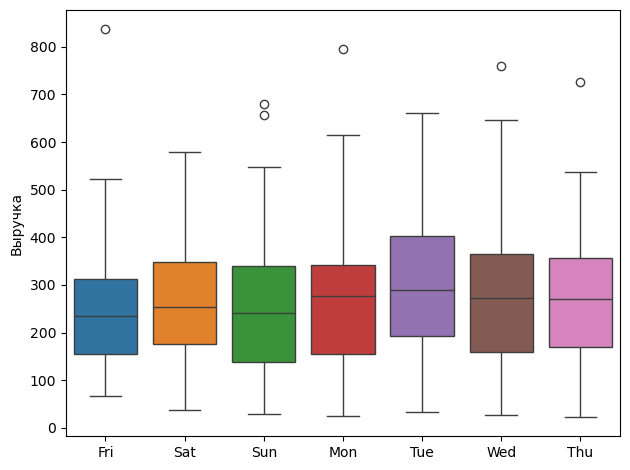

In [24]:
### YOUR CODE HERE

# В какие дни покупают больше напитков?
weekdays = []
for date in unique_dates:
    weekday = list(str(df_train.where(df_train['Date'].map(lambda x: x == date)).dropna()['Weekday']).split())[1][:4]
    weekdays.append(weekday)
weekdays_uniq_np = df_train['Weekday'].unique()
weekdays_uniq = []
for item in weekdays_uniq_np:
    weekdays_uniq.append(item)
weekday_stats = []
for weekday in weekdays_uniq:
    weekday_stat = []
    for i in range(len(weekdays)):
        if str(weekdays[i]) == str(weekday):
            weekday_stat.append(rewenues[i])
    weekday_stats.append(weekday_stat)
min_len = min([len(weekday_stat) for weekday_stat in weekday_stats])
for i in range(len(weekday_stats)):
    weekday_stats[i] = weekday_stats[i][:min_len]
boxes = {weekday: weekday_stats[weekdays_uniq.index(weekday)] for weekday in weekdays_uniq}
df_boxes = pd.DataFrame(boxes)
print(df_boxes.describe())
sns.boxplot(df_boxes)
plt.ylabel('Выручка')
plt.tight_layout()
plt.show()

По диаграмме с квантилями распределений: наибольшая выручка "в среднем" по вторникам

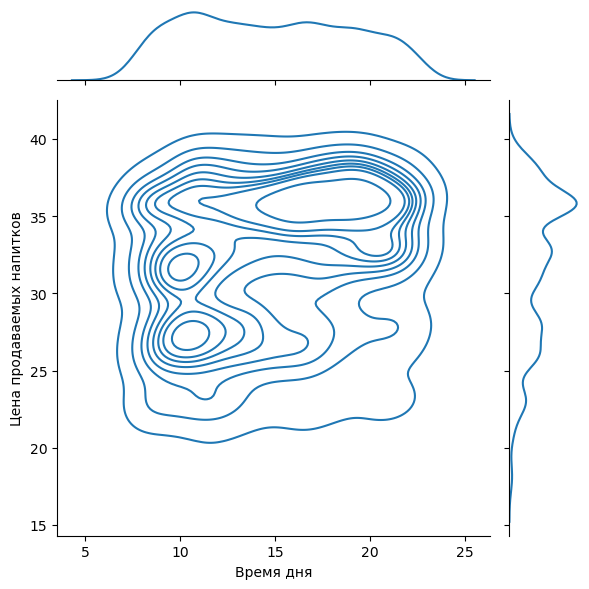

In [26]:
# В какое время?
money = df_train['money'].to_numpy()
tme = df_train['Time'].to_numpy()
time = np.array([float(t[:2])+float(t[3:5])/60 for t in tme])
sns.jointplot(x=time, y=money, kind="kde")
plt.xlabel('Время дня')
plt.ylabel('Цена продаваемых напитков')
plt.tight_layout()
plt.show()

Из диаграммы совместного распределения видно, что больше всего продаж происходит в период 10-11 часов, и в этот период наиболее популярны напитки по цене ~27 и ~32. А также повышенный спрос с в период 15-20 часов, в этот период особо популярны напитки по цене ~36

            Latte  Hot Chocolate   Americano  Americano with Milk       Cocoa  \
count  119.000000     119.000000  119.000000           119.000000  119.000000   
mean    38.140000      36.295294   28.356471            33.240000   35.545882   
std      0.487025       2.156709    0.489127             0.487025    1.745445   
min     37.720000      32.820000   27.920000            32.820000   32.820000   
25%     37.720000      35.760000   27.920000            32.820000   35.760000   
50%     37.720000      35.760000   27.920000            32.820000   35.760000   
75%     38.700000      37.720000   28.900000            33.800000   35.760000   
max     38.700000      38.700000   28.900000            33.800000   38.700000   

          Cortado    Espresso  Cappuccino  
count  119.000000  119.000000  119.000000  
mean    26.643529   20.837647   38.041176  
std      2.572525    2.055020    0.461944  
min     23.020000   18.120000   37.720000  
25%     23.020000   18.120000   37.720000  
50%   

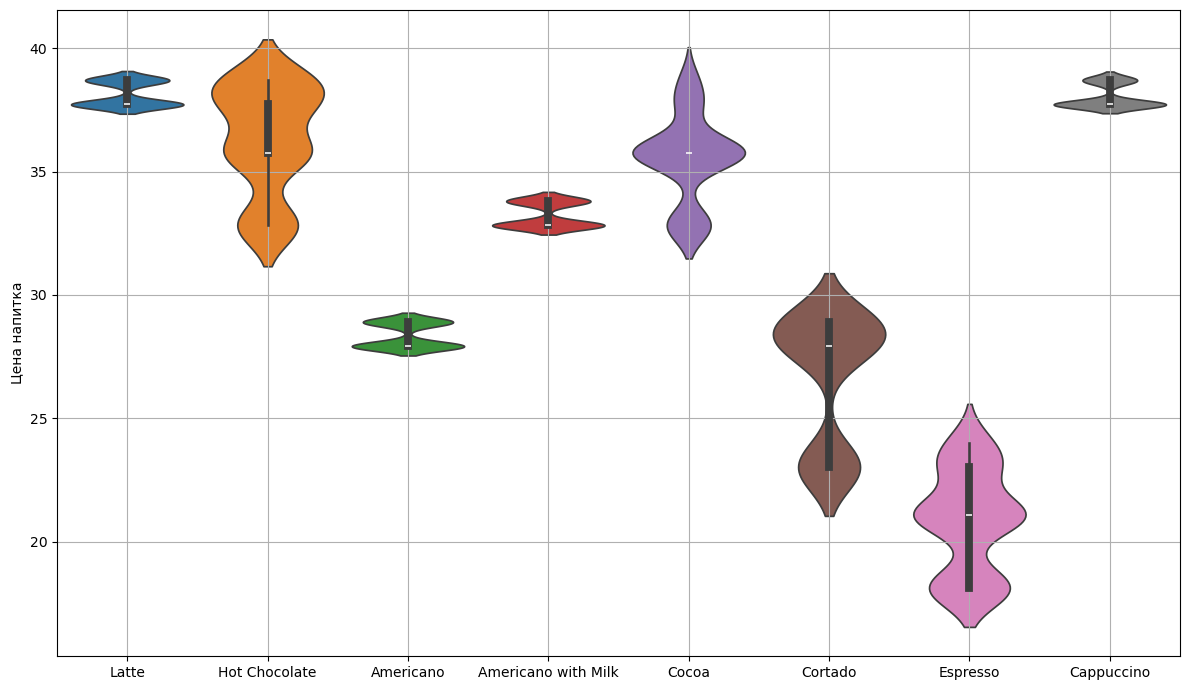

In [28]:
# Одинакова ли цена на напитки в рассматриваемый временной промежуток?
coffe_names_np = df_train['coffee_name'].unique()
coffe_names = []
for item in coffe_names_np:
    coffe_names.append(item)
coffe_names_stats = []
for coffe_name in coffe_names:
    coffe_names_stat = df_train.where(df_train['coffee_name'].map(lambda x: x == coffe_name)).dropna()['money'].to_numpy()
    coffe_names_stats.append(coffe_names_stat)
min_leng = min([len(coffe_names_stat) for coffe_names_stat in coffe_names_stats])
for i in range(len(coffe_names_stats)):
    coffe_names_stats[i] = coffe_names_stats[i][:min_leng]
bboxes = {coffe_name: coffe_names_stats[coffe_names.index(coffe_name)] for coffe_name in coffe_names}
df_bboxes = pd.DataFrame(bboxes)
print(df_bboxes.describe())
fig, ax1 = plt.subplots(figsize=(12, 7))
sns.violinplot(df_bboxes, ax=ax1)
plt.ylabel('Цена напитка')
plt.grid()
plt.tight_layout()
plt.show()

            Latte  Hot Chocolate   Americano  Americano with Milk       Cocoa  \
count  119.000000     119.000000  119.000000           119.000000  119.000000   
mean    14.785714      17.057143   13.840336            14.914846   15.274090   
std      3.813495       4.398965    3.096349             3.542030    4.609392   
min      8.450000       8.200000    7.966667             7.883333    7.816667   
25%     10.816667      12.741667   11.291667            12.041667   11.108333   
50%     14.816667      18.183333   13.583333            14.400000   15.150000   
75%     18.025000      21.066667   16.275000            18.000000   19.683333   
max     22.616667      22.850000   22.566667            22.800000   22.650000   

          Cortado    Espresso  Cappuccino  
count  119.000000  119.000000  119.000000  
mean    14.069328   14.121008   16.127591  
std      3.937942    3.537589    3.877886  
min      7.766667    7.750000    8.000000  
25%     11.083333   11.275000   13.033333  
50%   

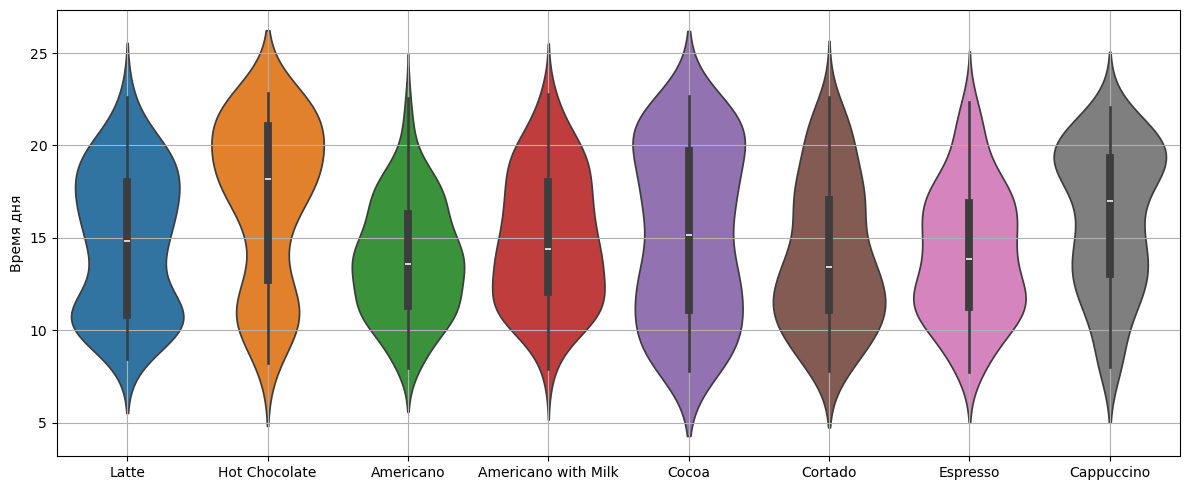

In [29]:
# Как ведут себя частоты покупки разных напитков?
coffe_names_stats_t = []
for coffe_name in coffe_names:
    coffe_names_stat_t = df_train.where(df_train['coffee_name'].map(lambda x: x == coffe_name)).dropna()['Time'].to_numpy()
    coffe_names_stat_tt = np.array([float(t[:2])+float(t[3:5])/60 for t in coffe_names_stat_t])
    coffe_names_stats_t.append(coffe_names_stat_tt)
min_length = min([len(coffe_names_stat_tt) for coffe_names_stat_tt in coffe_names_stats_t])
for i in range(len(coffe_names_stats_t)):
    coffe_names_stats_t[i] = coffe_names_stats_t[i][:min_length]
bboxes_t = {coffe_name: coffe_names_stats_t[coffe_names.index(coffe_name)] for coffe_name in coffe_names}
df_bboxes_t = pd.DataFrame(bboxes_t)
print(df_bboxes_t.describe())
fig, ax1 = plt.subplots(figsize=(12, 5))
sns.violinplot(df_bboxes_t, ax=ax1)
plt.ylabel('Время дня')
plt.grid()
plt.tight_layout()
plt.show()

### TASK 5 (OPTIONAL)

Сделайте попытку более качественно смоделировать распределение, учитывая факты, которые Вы узнали из разведочного анализа данных
(Если не получится - это ок)

Hints:
* Может быть оно не одинаково в зависимости от напитка?
* Или от времени и дня недели?
* Или стоит моделировать количество покупок и цену отдельно...
* А вообще здесь свобода творчества!

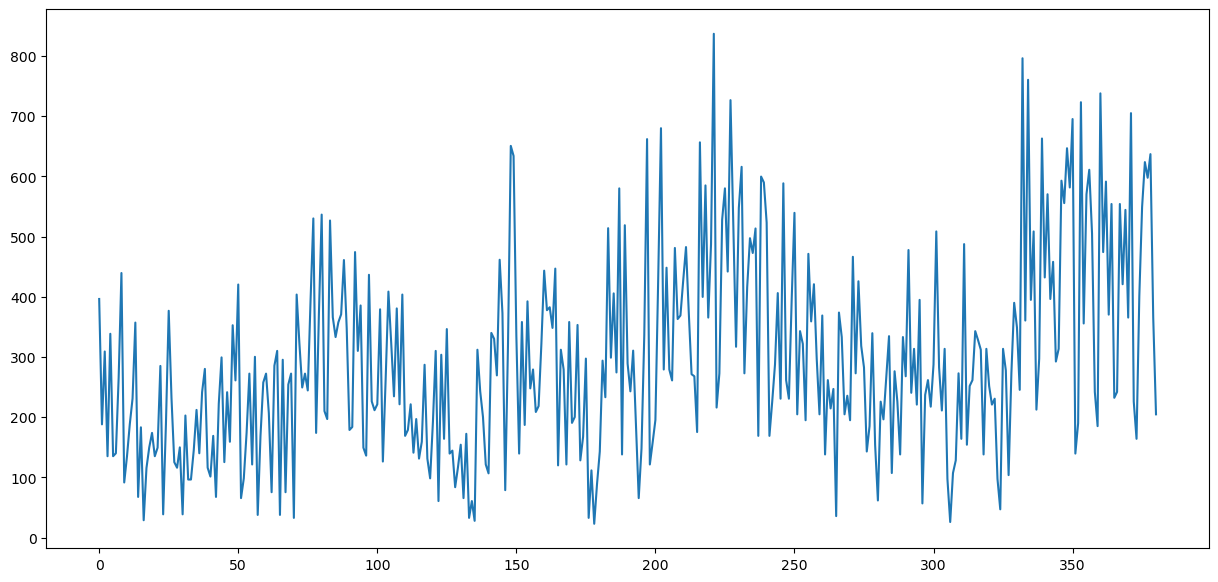

In [31]:
### YOUR CODE HERE
df_all = pd.read_csv("Coffe_sales.csv").drop(['hour_of_day', 'cash_type', 'coffee_name', 
                                              'Time_of_Day', 'Weekday', 'Month_name',
                                              'Weekdaysort', 'Monthsort', 'Time'], axis=1)
unique_dates_all = df_all['Date'].unique()
rewenues_all = []
for date in unique_dates_all:
    day_rewenue = df_all.where(df_all['Date'].map(lambda x: x == date)).dropna()['money'].sum()
    rewenues_all.append(day_rewenue)
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.plot(rewenues_all)
plt.show()

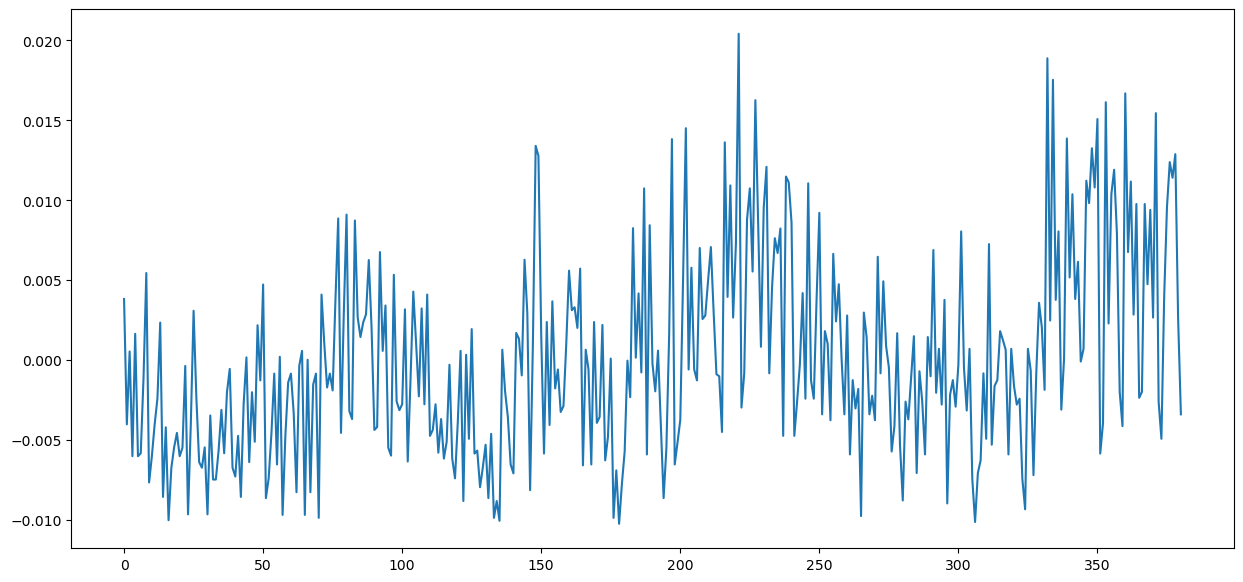

In [32]:
rew_expect = np.array(rewenues_all).mean()
rew_var = np.array(rewenues_all).var()
rewenues_all_st = list(map(lambda x: (x-rew_expect)/rew_var, rewenues_all))
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.plot(rewenues_all_st)
plt.show()

In [33]:
# data_in, data_out = [], []
# for i in range(7, len(rewenues_all_st), 1):
#     data_in.append(rewenues_all_st[i-7:i])
#     data_out.append(rewenues_all_st[i])
# data_in = np.array(data_in)
# data_out = np.array(data_out)
# data_in_train = data_in[:len(data_in)-23]
# data_in_test = data_in[len(data_in)-23:]
# data_out_train = data_out[:len(data_in)-23]
# data_out_test = data_out[len(data_in)-23:]
data_train = rewenues_all_st[:len(rewenues_all_st)-23]
data_test = rewenues_all_st[len(rewenues_all_st)-23:]

[0.958005249343832, 1.916010498687664, 2.8740157480314963, 4.79002624671916, 5.748031496062993, 17.244094488188978, 76.64041994750656]


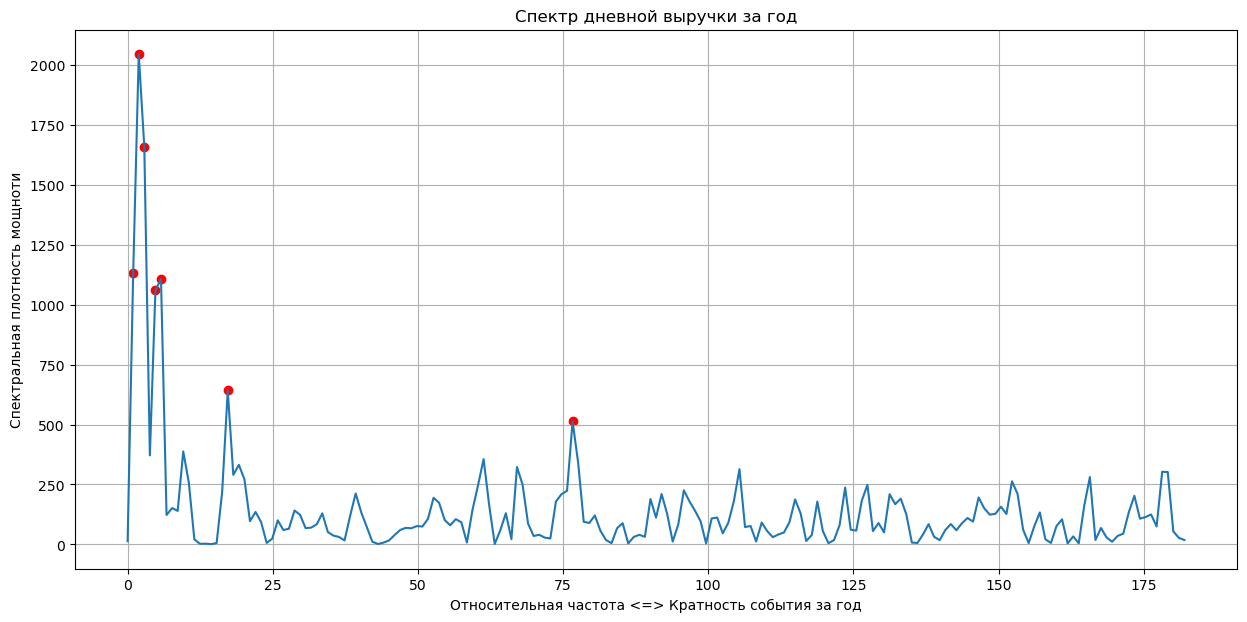

In [34]:
from scipy.signal import welch
freqs_year, dens_year = welch(x=rewenues_all, fs=365, nperseg=381, scaling='density')
# ds_year = list(map(lambda x: np.log(x)/np.log(10), dens_year))
fig, ax1 = plt.subplots(figsize=(15, 7))
max_10_dens = sorted(dens_year)[::-1][:7]
max_10_freqs = []
for i in max_10_dens:
    max_10_freqs.append(freqs_year[list(dens_year).index(i)])
print(sorted(max_10_freqs))
ax1.plot(freqs_year, dens_year)
ax1.scatter(max_10_freqs, max_10_dens, color='red')
plt.grid(True)
plt.xlabel('Относительная частота <=> Кратность события за год')
plt.ylabel('Cпектральная плотность мощноти')
plt.title('Спектр дневной выручки за год')
plt.show()

Наблюдаются сезонности на частотах: 2 дня, 5 дней, 17 дней и 77 дней

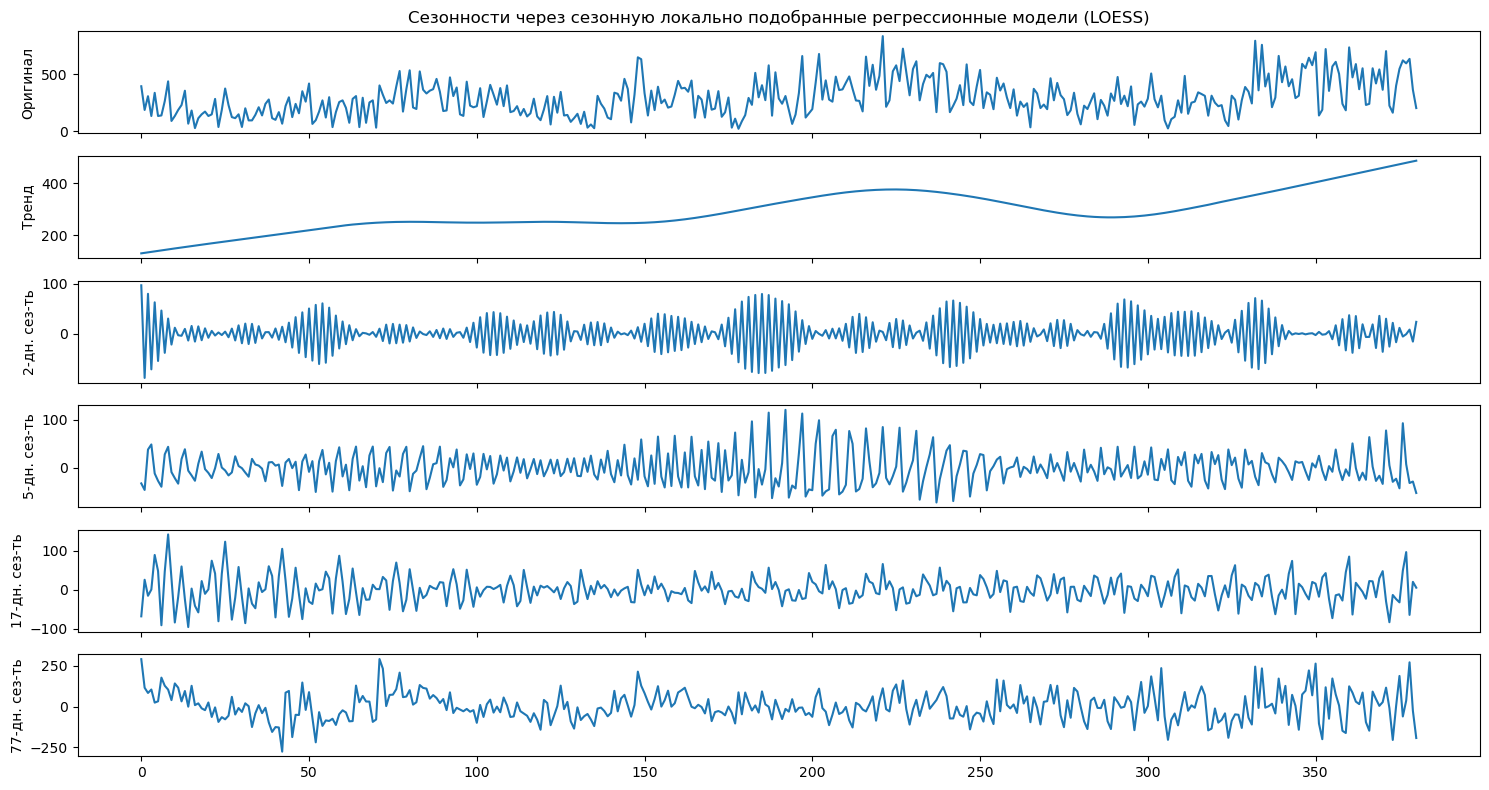

In [36]:
from statsmodels.tsa.seasonal import MSTL
mstl = MSTL(endog=pd.DataFrame({'r': rewenues_all}), periods=[2, 5, 17, 77])
res = mstl.fit()
fig, (axo, axt, ax2, ax5, ax17, ax77) = plt.subplots(6, 1, sharex=True, figsize=(15, 8))
axo.set_title('Сезонности через сезонную локально подобранные регрессионные модели (LOESS)')
axo.set_ylabel('Оригинал')
axo.plot(rewenues_all)
axt.set_ylabel('Тренд')
axt.plot(res.trend.to_numpy())
ax2.set_ylabel('2-дн. сез-ть')
ax2.plot(res.seasonal['seasonal_2'].to_numpy())
ax5.set_ylabel('5-дн. сез-ть')
ax5.plot(res.seasonal['seasonal_5'].to_numpy())
ax17.set_ylabel('17-дн. сез-ть')
ax17.plot(res.seasonal['seasonal_17'].to_numpy())
ax77.set_ylabel('77-дн. сез-ть')
ax77.plot(res.seasonal['seasonal_77'].to_numpy())
plt.tight_layout()
plt.show()

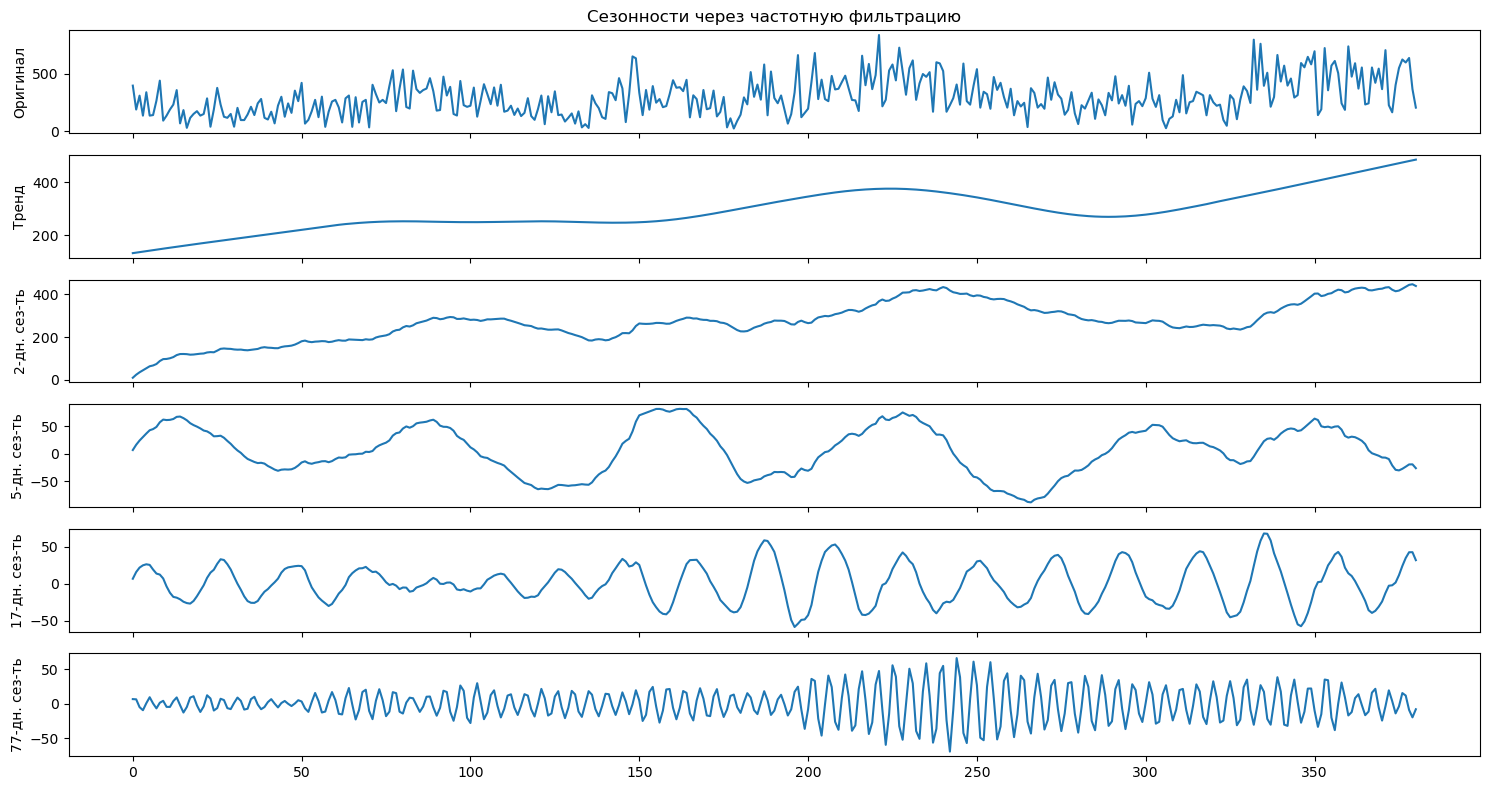

In [37]:
from scipy.signal import butter, sosfilt
d2_but = butter(1, 3, btype='lowpass', fs=365, output='sos')
d2 = sosfilt(d2_but, rewenues_all)
d5_but = butter(1, [4, 6], btype='bandpass', fs=365, output='sos')
d5 = sosfilt(d5_but, rewenues_all)
d17_but = butter(1, [16, 18], btype='bandpass', fs=365, output='sos')
d17 = sosfilt(d17_but, rewenues_all)
d77_but = butter(1, [76, 78], btype='bandpass', fs=365, output='sos')
d77 = sosfilt(d77_but, rewenues_all)
fig, (axo, axt, ax2, ax5, ax17, ax77) = plt.subplots(6, 1, sharex=True, figsize=(15, 8))
axo.set_title('Сезонности через частотную фильтрацию')
axo.set_ylabel('Оригинал')
axo.plot(rewenues_all)
axt.set_ylabel('Тренд')
axt.plot(res.trend.to_numpy())
ax2.set_ylabel('2-дн. сез-ть')
ax2.plot(d2)
ax5.set_ylabel('5-дн. сез-ть')
ax5.plot(d5)
ax17.set_ylabel('17-дн. сез-ть')
ax17.plot(d17)
ax77.set_ylabel('77-дн. сез-ть')
ax77.plot(d77)
plt.tight_layout()
plt.show()

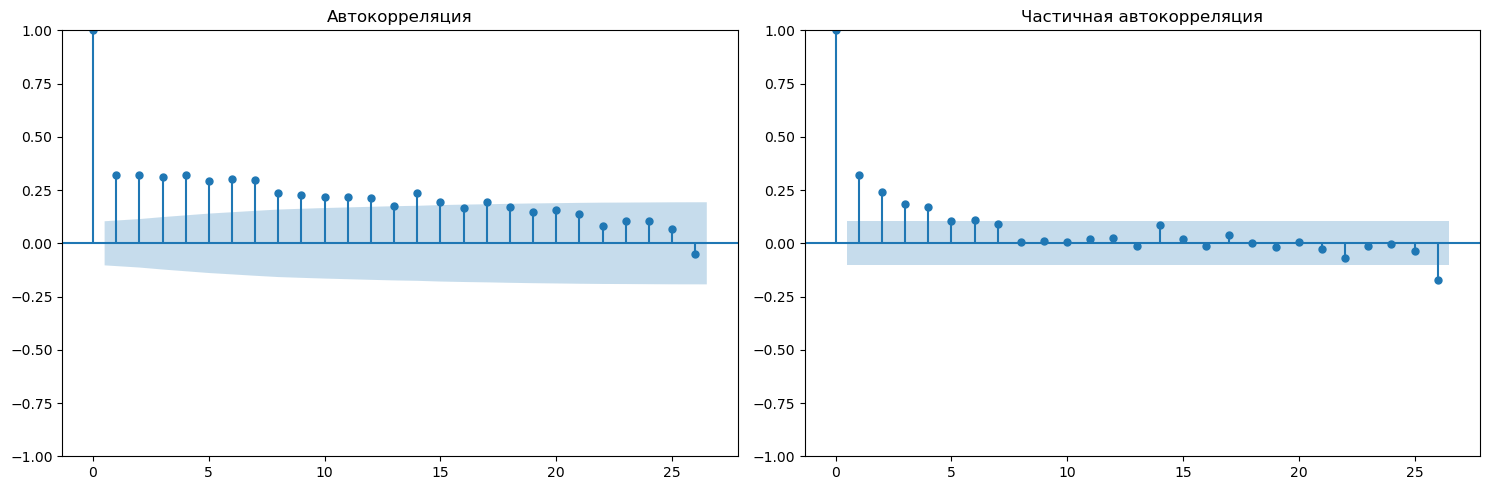

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
plot_acf(np.array(data_train), ax=ax1, title='Автокорреляция')
plot_pacf(np.array(data_train), ax=ax2, title='Частичная автокорреляция')
plt.tight_layout()
plt.show()

MAE моделирования по распределению: 183.01
MAE моделирования theta-моделью: 146.00


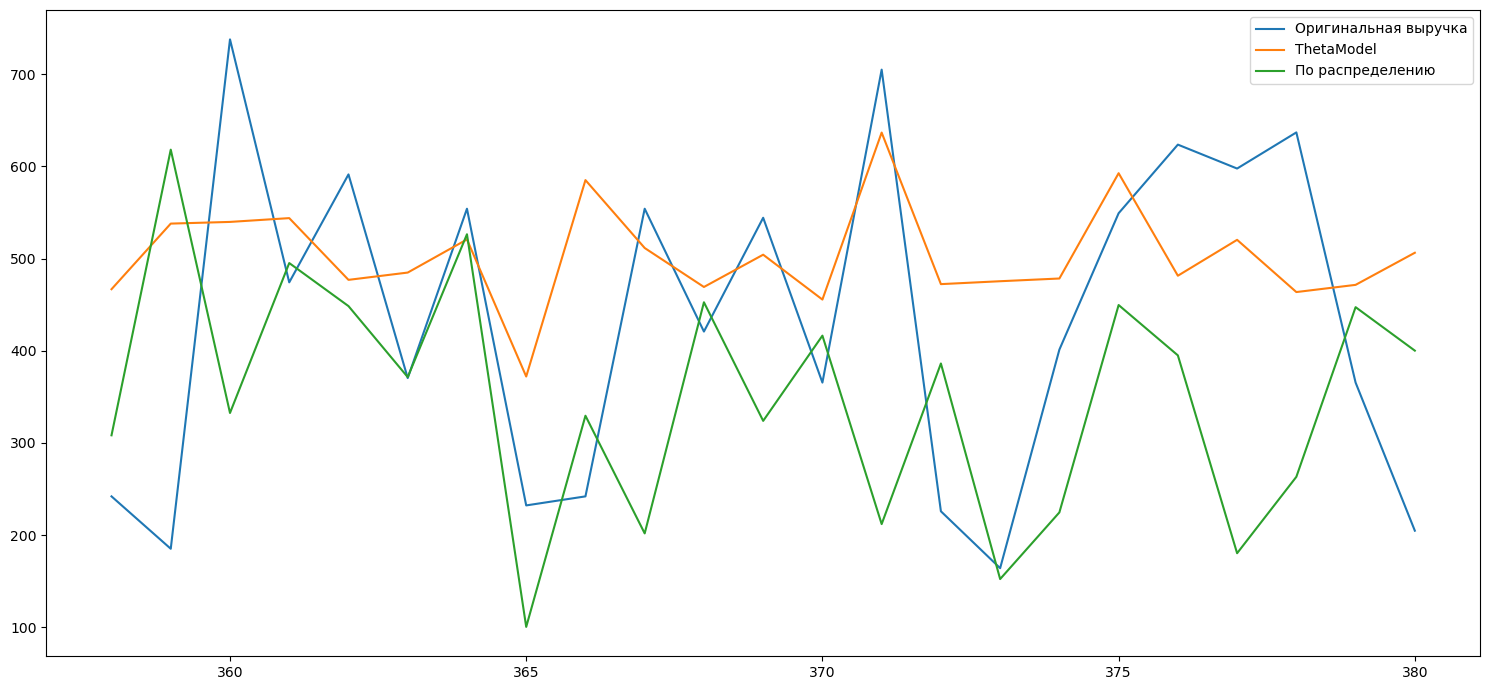

In [39]:
# https://www.statsmodels.org/stable/examples/notebooks/generated/theta-model.html
from statsmodels.tsa.forecasting.theta import ThetaModel
# best_period = 1
# best_mae = np.inf
# for per in range(1, len(data_train)):
#     tm = ThetaModel(endog=np.array(data_train), 
#                     period=per, 
#                     method="additive")
#     res = tm.fit(use_mle=True)
#     if mean_absolute_error(res.forecast(23), data_test) < best_mae:
#         best_period = per
#         best_mae = mean_absolute_error(res.forecast(23), data_test)
# print(best_period, best_mae) | 50 0.005463076800665538
tm = ThetaModel(endog=np.array(data_train), 
                    period=50, 
                    method="additive")
res = tm.fit(use_mle=True)
print(f'MAE моделирования по распределению: {mean_absolute_error(rewenues_test, modeled):.2f}')
print(f'MAE моделирования theta-моделью: {
      mean_absolute_error(list(map(lambda x: x*rew_var+rew_expect, res.forecast(23, theta=np.inf))), 
                          list(map(lambda x: x*rew_var+rew_expect, data_test))):.2f}')
fig, ax1 = plt.subplots(figsize=(15, 7))
# ax1.plot(data_train)
ax1.plot(list(range(len(data_train), len(data_train)+23, 1)), 
         list(map(lambda x: x*rew_var+rew_expect, data_test)), 
         label='Оригинальная выручка')
ax1.plot(list(range(len(data_train), len(data_train)+23, 1)), 
         list(map(lambda x: x*rew_var+rew_expect, res.forecast(23, theta=np.inf))), 
         label='ThetaModel')
ax1.plot(list(range(len(data_train), len(data_train)+23, 1)), 
         modeled, 
         label='По распределению')
plt.legend()
plt.tight_layout()
plt.show()

#### Вывод
Рассматривая данную задачу прогноза дневной выручки как задачу прогнозирования временного ряда, удалось построить решение с лучшим МАЕ, чем методом Монте-Карло 